## Configuration

In [43]:
DEVICE = 'cuda'
batch_size = 128
noise_dim = 64
# optimizers parameters 

lr = 0.002
beta_1 = 0.5
beta_2 = 0.99

#training variables 

epochs = 20


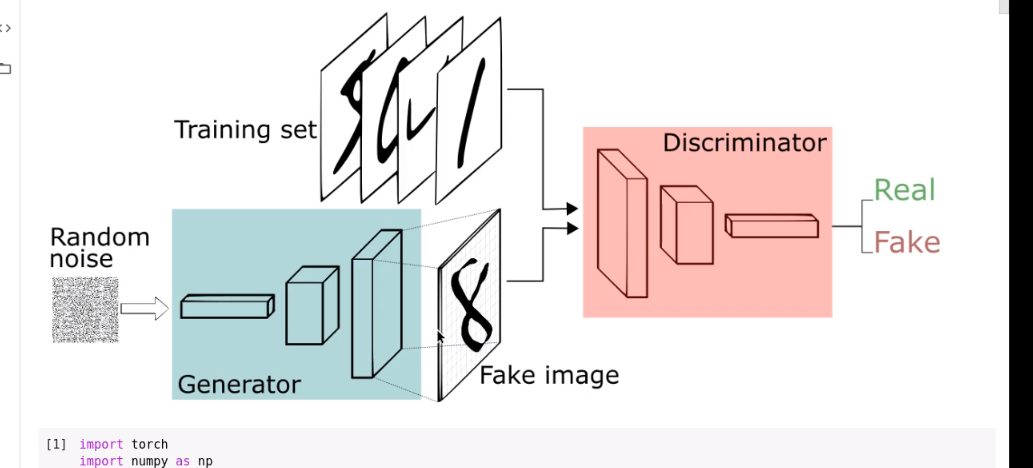

## Load MNIST

In [2]:
# !pip install torchvision

In [3]:
from torchvision import datasets, transforms as T

In [4]:
train_augs = T.Compose([
    T.RandomRotation((-20, 20)),
    T.ToTensor() # (h, w, c) -> (c, h, w)
])

In [5]:
trainset = datasets.MNIST('MNIST/' , download = True , train = True, transform = train_augs)

In [6]:
import matplotlib.pyplot as plt

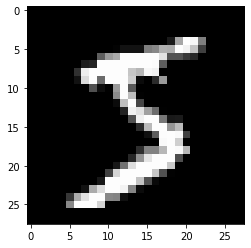

In [7]:
image , label = trainset[0]
plt.imshow(image.squeeze(), cmap ='gray')

In [8]:
print(len(trainset))

60000


## Load Dataset Into Batches

In [9]:
from torch.utils.data import DataLoader
from torchvision.utils import make_grid

In [10]:
trainloader = DataLoader(trainset, batch_size=batch_size, shuffle=True)
print(len(trainloader))

469


In [11]:
data_iter = iter(trainloader)  # load batch 

In [12]:
images , _ = data_iter.next()
print('one batch contain')
print(images.shape)

one batch contain
torch.Size([128, 1, 28, 28])


In [13]:
def show_tensor_images(tensor_img, num_images = 16, size=(1,28, 28)):
    unflat_img = tensor_img.detach().cpu()
    img_grid = make_grid(unflat_img[:num_images], rows = 4)
    plt.imshow(img_grid.permute(1,2,0).squeeze())
    plt.show()

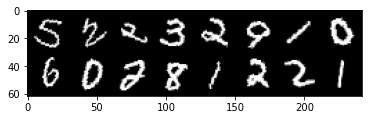

In [14]:
show_tensor_images(images, num_images = 16)

### Create Discriminator Network

In [15]:
from torch import nn
from torchsummary import summary

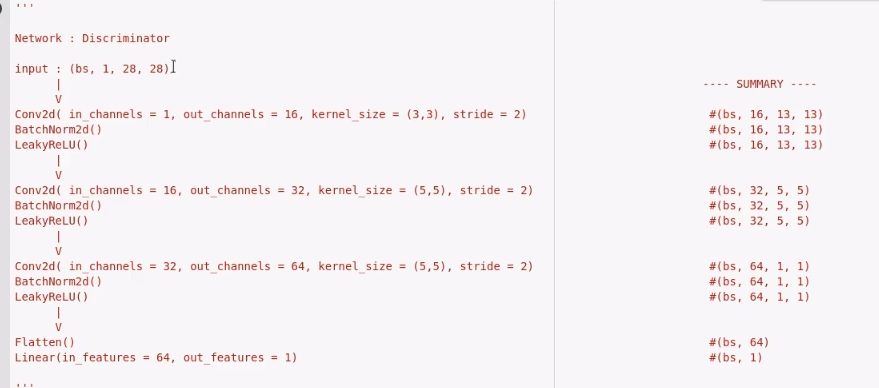

In [29]:
def get_disc_block(in_channels, out_channels, kernel_size, stride):
    return nn.Sequential(
        nn.Conv2d(in_channels, out_channels, kernel_size, stride),
        nn.BatchNorm2d(out_channels),
        nn.LeakyReLU(0.2)
    )

In [30]:
class Discriminator(nn.Module):
    
    def __init__(self):
        super(Discriminator, self).__init__()
        
        self.block_1 = get_disc_block(1, 16, (3,3), 2)
        self.block_2 = get_disc_block(16,32,(5,5), 2)
        self.block_3 = get_disc_block(32,64, (5,5), 2)

        self.flatten = nn.Flatten()
        self.linear = nn.Linear(in_features=64, out_features= 1)

    def forward(self, images):
        x1 = self.block_1(images)
        x2 = self.block_2(x1)
        x3 = self.block_3(x2)

        x4 = self.flatten(x3)
        x5 = self.linear(x4)

        return x5


In [31]:
D = Discriminator()
D.to(DEVICE)

summary(D, input_size= (1,28,28))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 16, 13, 13]             160
       BatchNorm2d-2           [-1, 16, 13, 13]              32
         LeakyReLU-3           [-1, 16, 13, 13]               0
            Conv2d-4             [-1, 32, 5, 5]          12,832
       BatchNorm2d-5             [-1, 32, 5, 5]              64
         LeakyReLU-6             [-1, 32, 5, 5]               0
            Conv2d-7             [-1, 64, 1, 1]          51,264
       BatchNorm2d-8             [-1, 64, 1, 1]             128
         LeakyReLU-9             [-1, 64, 1, 1]               0
          Flatten-10                   [-1, 64]               0
           Linear-11                    [-1, 1]              65
Total params: 64,545
Trainable params: 64,545
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.00
Forward/ba

### Generator Network

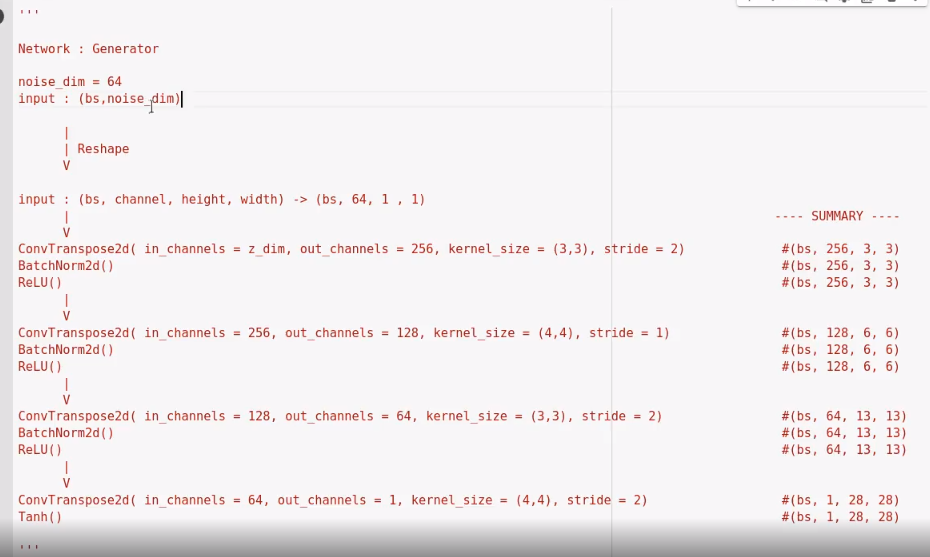

In [32]:
def get_gen_block(in_channels, out_channels, kernel , stride, final_block = False):
    
    if final_block==True:
        return nn.Sequential(
            nn.ConvTranspose2d(in_channels, out_channels , kernel, stride),
            nn.Tanh()
        )
    
    return nn.Sequential(
        nn.Conv2d(in_channels, out_channels, kernel , stride ),
        nn.BatchNorm2d(out_channels),
        nn.ReLU()
    )


In [33]:
class Generator(nn.Module):
    def __init__(self, noise_dim):
        super(Generator, self).__init__()
        self.noise_dim = noise_dim
        self.block_1 = get_gen_block (noise_dim, 256, (3,3), 2)
        self.block_2 = get_gen_block(256, 128, (4,4), 1)
        self.block_3 = get_gen_block(128, 64, (3,3), 2)
        self.block_4 = get_gen_block(64, 1, (4,4), 2, final_block =True)
        
    def forward(self, r_noise_vec):
    #(bs, noise dim)-> (bs, noise dim, 1, 1)
        x = r_noise_vec.view(-1, self.noise_dim, 1, 1)
        x1 = self.block_1(x)
        x2 = self.block_2(x1)
        x3 = self.block_3(x2)
        x4 = self.block_4(x3)
        return x4

In [35]:
G = Generator(noise_dim)
G.to(DEVICE)
summary(G , input_size=(1, noise_dim))

RuntimeError: Calculated padded input size per channel: (1 x 1). Kernel size: (3 x 3). Kernel size can't be greater than actual input size

In [36]:
# Replace Random initialized weights to Normal Weights
def weights_init(m):
    if isinstance (m, nn.Conv2d) or isinstance (m, nn.ConvTranspose2d):
        nn.init.normal_(m.weight, 0.0, 0.02)
    if isinstance (m, nn.BatchNorm2d):
        nn.init.normal_(m.weight, 0.0, 0.02)
        nn.init.constant_(m.bias, 0)

In [37]:
D = D.apply(weights_init)
G = G.apply(weights_init)

In [40]:
import torch

## Create Loss Function and Load Optimizer 

In [41]:
def real_loss(disc_pred):
    criterion = nn.BCEWithLogitsLoss()
    ground_truth = torch.ones_like(disc_pred)
    loss = criterion(disc_pred, ground_truth)
    return loss

def fake_loss(disc_pred):
    criterion = nn.BCEWithLogitsLoss()
    ground_truth = torch.zero_like(disc_pred)
    loss = criterion(disc_pred, ground_truth)
    return loss

In [44]:
D_opt = torch.optim.Adam (D.parameters(), lr = lr, betas = (beta_1, beta_2))
G_opt = torch.optim.Adam (G.parameters(), lr = lr, betas = (beta_1, beta_2))

## Training Loop

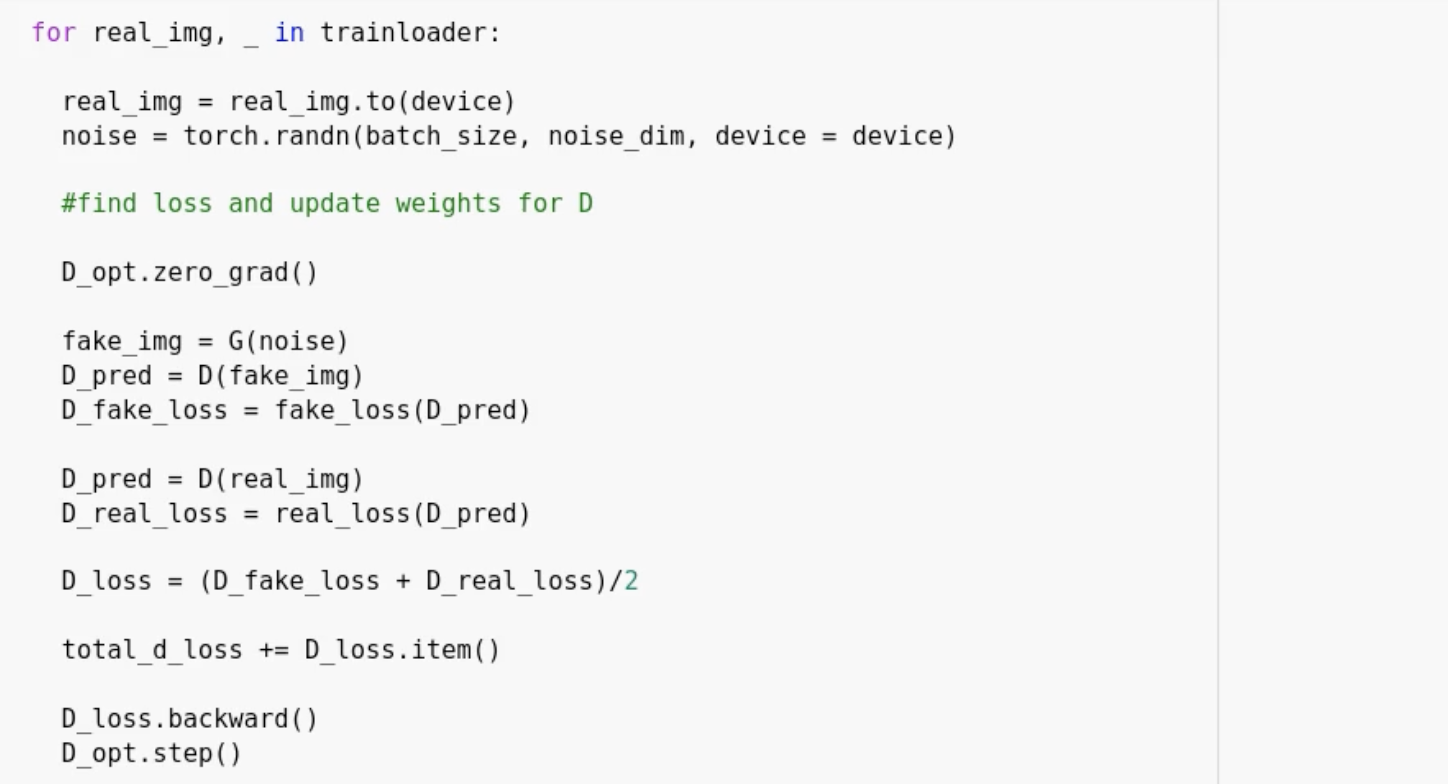
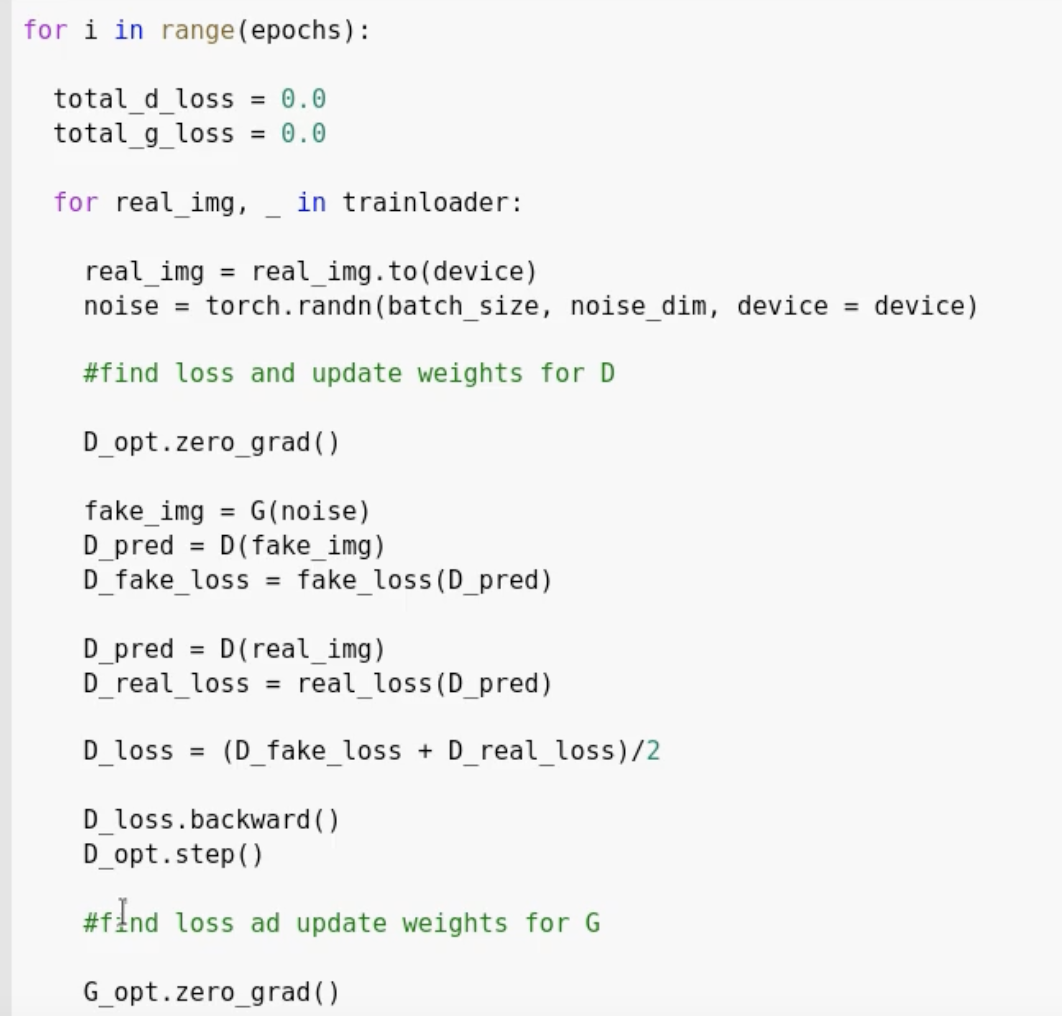

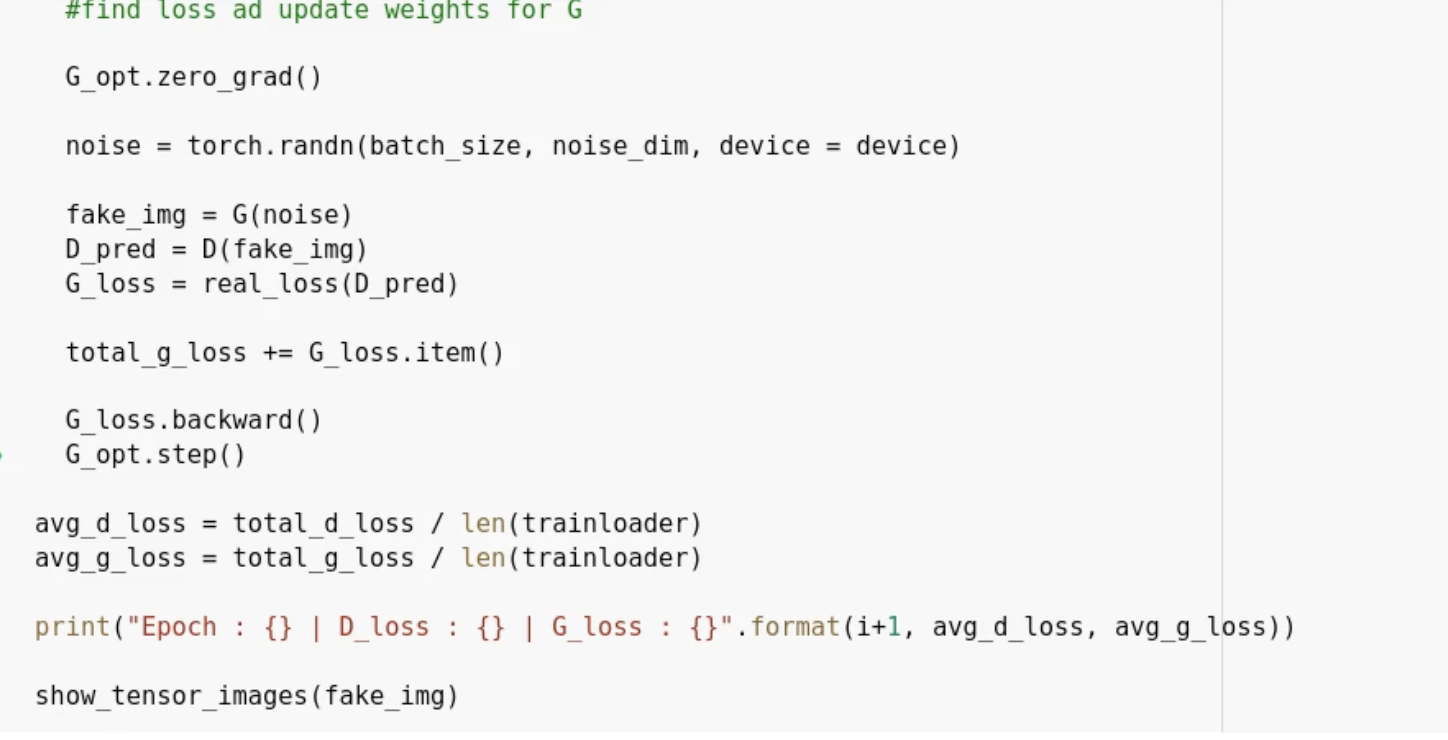
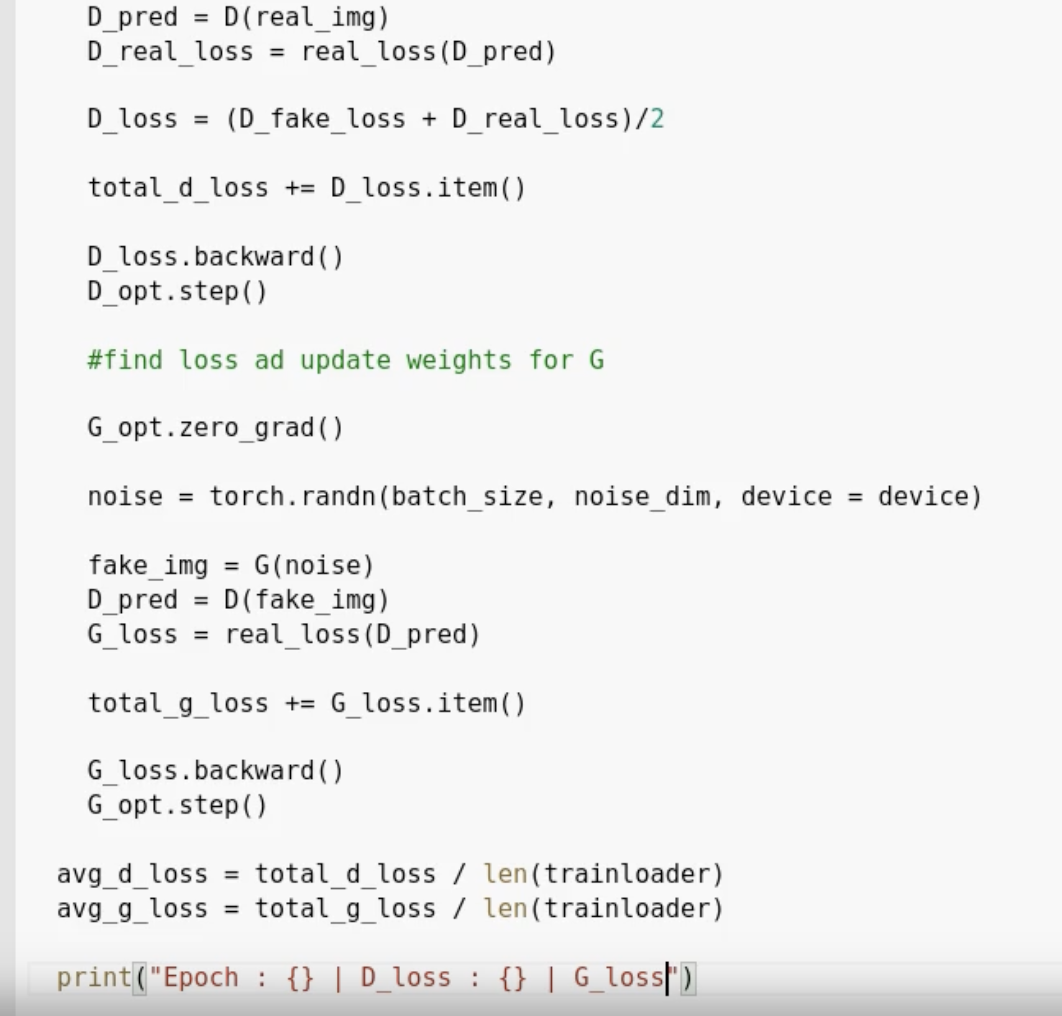